# Predicting customer satisfaction at Olist - a Brazilian e-commerce platform

## DATA PREPARATION 

Import libraries

In [165]:
import pandas as pd
import numpy as np
import os
import bisect 

### OLIST DATA

In [166]:
folder_path = str(os.getcwd()) + '/'
customers = pd.read_csv(folder_path + 'olist_customers_dataset.csv')
geolocation =  pd.read_csv(folder_path + 'olist_geolocation_dataset.csv')
order_items =  pd.read_csv(folder_path + 'olist_order_items_dataset.csv')
order_payments =  pd.read_csv(folder_path + 'olist_order_payments_dataset.csv')
order_reviews =  pd.read_csv(folder_path + 'olist_order_reviews_dataset.csv')
order_info =  pd.read_csv(folder_path + 'olist_orders_dataset.csv')
products_info = pd.read_csv(folder_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(folder_path + 'olist_sellers_dataset.csv')
product_category = pd.read_csv(folder_path + 'olist_product_category_name_translation.csv')

#### Customers
This dataset contains information about the customer id and their location in Brazil, which can be used to track the order delivery location and especially analyze each customer's purchasing experience.

Each customer is assigned a customer_unique_id, while a new customer_id is assigned for every time they make an order. This is a way to track repeating customers, which is crucial for an e-commerce platform.

In [167]:
print(customers.shape)
customers.head(3)

(99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


Create dummy variable for customer return

In [168]:
customers['customer_return'] = customers.duplicated(subset=['customer_unique_id']).astype(int)
customers['customer_return'].value_counts() #Highly unbalanced but will keep for final table

0    96096
1     3345
Name: customer_return, dtype: int64

Drop unwanted columns & rename the state column to join with social-economic data later.

In [169]:
customers.drop(['customer_city', 'customer_unique_id'], axis=1, inplace=True)
customers.rename(columns={"customer_state": "state_code"}, inplace=True)

#### Geolocation
This dataset contains Brazilian zip codes and its lat/lng coordinates. This can be useful to analyze the shipping distances and do geospartial visualization.

In [170]:
print(geolocation.shape)
geolocation.head(3)

(1000163, 5)


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


Drop unwanted columns & drop duplicates to keep only one lat/long pair per zip_code prefix.

In [171]:
geolocation = geolocation.drop(['geolocation_city', 'geolocation_state'], axis=1)
geolocation = geolocation.drop_duplicates(subset = ['geolocation_zip_code_prefix'],ignore_index=True)

Create 2 new data frames to join with customer data later.

In [172]:
geo_customer = geolocation.rename(columns={"geolocation_zip_code_prefix":"customer_zip_code_prefix",
                                                  "geolocation_lat":"customer_lat",
                                                  "geolocation_lng":"customer_lng"})
geo_seller = geolocation.rename(columns={"geolocation_zip_code_prefix":"seller_zip_code_prefix",
                                                  "geolocation_lat":"seller_lat",
                                                  "geolocation_lng":"seller_lng"})
geo_customer.head(3)

,customer_zip_code_prefix,customer_lat,customer_lng
0,1037,-23.545621,-46.639292
1,1046,-23.546081,-46.644820
2,1041,-23.544392,-46.639499


#### Order items
This dataset has information about the products in each order. Prices are in Brazilian currency - reais. Freight value is calculated according to each item measures and weight.

In [173]:
print(order_items.shape)
order_items.head(3)

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


Shipping_limit_date indicates limit date for seller to handle the order over to the logistic partner. It's a step in shipping process, but it's the actual delivery time that affect customer satisfaction, so we'll drop this attribute.

In [174]:
order_items.drop('shipping_limit_date', axis=1, inplace=True)

The order_item_id represents the item quantity in each order. Due to the lack of connection between the product, order and review data sets, it's not possible to link each product in a multi-item order to its own review. Therefore, we'll only keep single-item orders.

In [175]:
rows_to_keep = len(order_items.loc[order_items['order_item_id'] == 1,])
print('Number of single-item orders to keep: ', rows_to_keep)
print('Percentage: ', rows_to_keep/len(order_items)*100)

Number of single-item orders to keep:  98666
Percentage:  87.58632933865957


In [176]:
order_items_restricted = order_items.loc[order_items['order_item_id'] == 1,]
order_items_restricted.drop('order_item_id', axis=1, inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Order reviews

In [177]:
print(order_reviews.shape)
order_reviews.head(3)

(100000, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [178]:
print('Duplicates in order_id: ', order_reviews['order_id'].duplicated().sum())
print('Duplicates in review_id: ', order_reviews['review_id'].duplicated().sum())

Duplicates in order_id:  559
Duplicates in review_id:  827


Take out dupplicates for same order_id by selecting the latest review based on review_answer_timestamp, as the data is already sorted by time. Then take out dupplicated reviews due to the issue mentioned above with multi-item orders & multi reviews.

In [179]:
order_reviews.drop_duplicates(subset=['order_id'], keep='last', ignore_index=True, inplace=True)
order_reviews.drop_duplicates(subset=['review_id'], keep=False, ignore_index=True, inplace=True)

Create a new attribute to capture the time each customer takes to respond to survey after purchasing. Then drop the timestamp columns.

In [180]:
order_reviews['review_answer_timestamp'] = pd.to_datetime(order_reviews['review_answer_timestamp'], format='%Y/%m/%d')
order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date'], format='%Y/%m/%d')
order_reviews['review_answer_delay'] = (order_reviews['review_answer_timestamp'] - order_reviews['review_creation_date']).dt.days

Check missing values.

In [181]:
order_reviews.isna().sum() / len(order_reviews)

review_id                  0.000000
order_id                   0.000000
review_score               0.000000
review_comment_title       0.881906
review_comment_message     0.582043
review_creation_date       0.000000
review_answer_timestamp    0.000000
review_answer_delay        0.000000
dtype: float64

The columns with text reivews are in Portugese and have more than 50% of values missing, so we'll drop them.

In [182]:
order_reviews = order_reviews.drop(['review_id', 'review_comment_title', 'review_comment_message', 
                                    'review_creation_date', 'review_answer_timestamp'], axis=1)
order_reviews.head(3)

,order_id,review_score,review_answer_delay
0,73fc7af87114b39712e6da79b0a377eb,4,0
1,a548910a1c6147796b98fdf73dbeba33,5,1
2,f9e4b658b201a9f2ecdecbb34bed034b,5,1


#### Order info
This data set tracks the order status and the shipping process.

In [183]:
print(order_info.shape)
order_info.head(3)

(99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [184]:
order_info.isna().sum() / len(order_reviews)

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001627
order_delivered_carrier_date     0.018130
order_delivered_customer_date    0.030149
order_estimated_delivery_date    0.000000
dtype: float64

Create aggregated attributes to track the shipping process.

In [185]:
# changing dtype to date
order_info.loc[:,'order_purchase_timestamp'] = pd.to_datetime(order_info['order_purchase_timestamp'],
                                                              format='%Y/%m/%d').dt.date
order_info.loc[:,'order_delivered_customer_date'] = pd.to_datetime(order_info['order_delivered_customer_date'],
                                                              format='%Y/%m/%d').dt.date
order_info.loc[:,'order_estimated_delivery_date'] = pd.to_datetime(order_info['order_estimated_delivery_date'],
                                                              format='%Y/%m/%d').dt.date

# track the estimated & actual days of delivery
order_info['estimated_days_of_delivery'] = (order_info['order_estimated_delivery_date'] 
                                            - order_info['order_purchase_timestamp']).astype('timedelta64[D]')
order_info['actual_days_of_delivery'] = (order_info['order_delivered_customer_date'] 
                                            - order_info['order_purchase_timestamp']).astype('timedelta64[D]')

Create a year column as a key join with the socio-economic data later.

In [186]:
order_info['year'] = pd.to_datetime(order_info['order_purchase_timestamp'], format='%Y/%m/%d').dt.year

Drop rows with order_status as canceled or unavailable. Drop irrelevant columns.

In [187]:
order_info = order_info[(~order_info['order_status'].isin(['canceled', 'unavailable']))]

cols_to_drop = ['order_approved_at', 'order_delivered_carrier_date', 
               'order_delivered_customer_date', 'order_estimated_delivery_date'] 
order_info = order_info.drop(cols_to_drop, axis=1)
order_info.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,estimated_days_of_delivery,actual_days_of_delivery,year
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,16.0,8.0,2017
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,20.0,14.0,2018
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,27.0,9.0,2018


#### Sellers
This data set contains seller id and their location information.

In [188]:
print(sellers.shape)
sellers.head(3)

(3095, 4)


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


Drop seller_city & seller_state.

In [189]:
sellers.drop(['seller_city', 'seller_state'], axis=1, inplace=True)

#### Product info & categories
These data sets give details about Olist's products and their categories.

In [190]:
print(products_info.shape)
products_info.head(3)

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


Join product info & category to get the category names in English, then drop the Portugese category names.

In [191]:
products = pd.merge(products_info, product_category, on='product_category_name', how='left')

products.drop('product_category_name', axis=1, inplace=True)

products = products.rename(columns={"product_name_lenght": "product_name_length", 
                                              "product_description_lenght": "product_description_length",
                                             "product_category_name_english": "product_category_name"})

In [192]:
products.isna().sum()

product_id                      0
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
product_category_name         623
dtype: int64

Assign the missing values in product_category_name as 'not_reported'.

In [193]:
products['product_category_name'] = products['product_category_name'].fillna('not_reported')
products.head(3)

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure


Regroup the product categories & create dummy variables for this new categorical variable.

In [194]:
product_group = pd.read_csv(folder_path + 'product_group.csv', sep = ';')

In [195]:
# join product with the new groups we created in order to delete the category name
products = pd.merge(products, product_group, on='product_category_name', 
                                    how='left')
products = products.drop('product_category_name', axis=1)

### IGBE DATA
To add another point of view to the Olist internal data, we'll explore 2 social-economic data of Brazil by state, during the same period of time. Our hypothesis is the social-economic context of each state may have an impact on their inhabitants' purchasing power in general, and on their purchasing habit at Olist in particular.

The data was retrieved from the official website of Brazilian Institute of Geography and Statistics:

https://www.ibge.gov.br/en/statistics/social/income-expenditure-and-consumption/18704-summary-of-social-indicators.html?=&t=resultados

https://www.ibge.gov.br/en/statistics/social/population/18448-estimates-of-resident-population-for-municipalities-and-federation-units.html?edicao=21737&t=downloads

#### Brazil state codes
Import state codes to join with Olist data. Drop the irrelevant rows, only keep the state names & state codes.

In [197]:
state_codes = pd.read_excel(folder_path + 'state_codes.xlsx', usecols=[0,1], names=['state_name','state_code'])

state_codes = state_codes[state_codes['state_code'].notnull()]
print(state_codes.shape)
state_codes.head(3)

(27, 2)


,state_name,state_code
0,Acre,AC
1,Alagoas,AL
2,Amapá,AP


#### Brazil's average household income by state
Import Brazil household income data from 2016 to 2018.

In [198]:
avg_income_2016 = pd.read_excel(folder_path + 'Tabela 2.1 UF.xls', sheet_name='2016', 
                        skiprows=[0,1,2,3,4,5], usecols=[0,1], names=['state_name', '2016'])
avg_income_2017 = pd.read_excel(folder_path + 'Tabela 2.1 UF.xls', sheet_name='2017', 
                        skiprows=[0,1,2,3,4,5], usecols=[0,1], names=['state_name', '2017'])
avg_income_2018 = pd.read_excel(folder_path + 'Tabela 2.1 UF.xls', sheet_name='2018', 
                        skiprows=[0,1,2,3,4,5], usecols=[0,1], names=['state_name', '2018'])

Clean the duplicates and rows with missing values.

In [199]:
for file in [avg_income_2016, avg_income_2017, avg_income_2018]:
    file.drop_duplicates(subset=['state_name'], keep = 'first', inplace=True)
    file.dropna(axis=0, inplace=True)
    file.reset_index(drop=True, inplace=True)

Create a table with full income data by state in three years.

In [200]:
avg_household_income = avg_income_2016.merge(avg_income_2017, on='state_name', how='left')\
                                      .merge(avg_income_2018, on='state_name', how='left')

avg_household_income = pd.melt(avg_household_income, id_vars=['state_name'], value_vars=['2016', '2017', '2018'], 
                              var_name='year', value_name='avg_income')

# create a column 'year' as a key to join later
avg_household_income['year'] = avg_household_income['year'].astype(int)

Join with state_codes & drop missing values.

In [201]:
avg_household_income = pd.merge(avg_household_income, state_codes, on='state_name', how='left')
avg_household_income.dropna(axis=0, inplace=True)
print(avg_household_income.shape)
avg_household_income.head(3)

(81, 4)


,state_name,year,avg_income,state_code
2,Rondônia,2016,969.428894,RO
4,Acre,2016,832.458072,AC
6,Amazonas,2016,799.594705,AM


#### Brazil population by state
Import Brazil population data from IGBE.

In [202]:
pop = pd.read_excel(folder_path + 'serie_2001_2018_TCU.xls', skiprows=[0,1,2,3,4,5,6], header=None, 
                    usecols=[0, 16, 17, 18], names=['state_name', '2016', '2017', '2018'], nrows=32)

Manually fix the inconsistent data type in column 2018.

In [203]:
pop['2018'] = pop['2018'].astype(str)
pop.iloc[10,3] = pop.iloc[10,3].replace(" (*)","").replace(".","")
pop.iloc[11,3] = pop.iloc[11,3].replace(" (*)","").replace(".","")
pop.iloc[14,3] = pop.iloc[14,3].replace(" (**)","").replace(".","")
pop.iloc[15,3] = pop.iloc[15,3].replace(" (**)","").replace(".","")
pop.iloc[30,3] = pop.iloc[30,3].replace(" (***)","").replace(".","")
pop.iloc[31,3] = pop.iloc[31,3].replace(" (***)","").replace(".","")
pop['2018'] = pop['2018'].astype(int)

Create a new table of population by state and year.

In [204]:
population = pd.melt(pop, id_vars=['state_name'], value_vars=['2016', '2017', '2018'],
             var_name='year', value_name='state_population')
population['year'] = population['year'].astype(int)

Join with state codes & drop missing values.

In [205]:
population = pd.merge(population, state_codes, on='state_name', how='left').drop('state_name', axis=1)
population.dropna(axis=0, inplace=True)
print(population.shape)
population.head(3)

(81, 3)


,year,state_population,state_code
1,2016,1787279,RO
2,2016,816687,AC
3,2016,4001667,AM


### FINAL TABLE
#### Join data

In [206]:
final_df = order_items_restricted.merge(order_info, on = 'order_id', how = 'inner')
final_df = final_df.merge(products, on = 'product_id', how = 'left')
final_df = final_df.merge(order_reviews, on = 'order_id', how = 'inner')
final_df = final_df.merge(customers, on = 'customer_id', how = 'left')
final_df = final_df.merge(sellers, on = 'seller_id', how='left')
final_df = final_df.merge(geo_customer, on = 'customer_zip_code_prefix', how = 'left')
final_df = final_df.merge(geo_seller, on = 'seller_zip_code_prefix', how = 'left')
final_df = pd.merge(final_df, avg_household_income, on=['state_code', 'year'], how='left')
final_df = final_df.merge(population, on=['state_code', 'year'], how='left')

#### Treat missing values

In [207]:
final_df.isna().sum()

order_id                         0
product_id                       0
seller_id                        0
price                            0
freight_value                    0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
estimated_days_of_delivery       0
actual_days_of_delivery       1700
year                             0
product_name_length           1387
product_description_length    1387
product_photos_qty            1387
product_weight_g                16
product_length_cm               16
product_height_cm               16
product_width_cm                16
product_category                 0
review_score                     0
review_answer_delay              0
customer_zip_code_prefix         0
state_code                       0
customer_return                  0
seller_zip_code_prefix           0
customer_lat                   269
customer_lng                   269
seller_lat                     213
seller_lng          

##### Actual days of delivery

Average days of delivery (by the median value):  10.0


<AxesSubplot:ylabel='Frequency'>

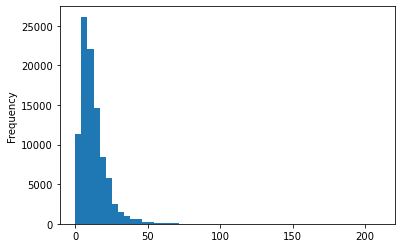

In [208]:
print('Average days of delivery (by the median value): ', final_df['actual_days_of_delivery'].median())
final_df['actual_days_of_delivery'].plot.hist(bins=50)

In [209]:
final_df[final_df.actual_days_of_delivery.isna()]['order_status'].value_counts()

shipped       1085
invoiced       307
processing     298
delivered        8
approved         2
Name: order_status, dtype: int64

For customer review, Olist sends survey to customers when the order is delivered or the estimated time of delivery is passed. So for those orders that don't have the delivery date yet but still have review scores, it means they haven't been delivered at the time of review.

Based on the average actual delivery days and each order's status, we estimate the extra time (on top of the estimated delivery time for each order) as follows: 

    - shipped: +5 days
    - invoiced/processing/approved: + 10 days
    - delivered: +1 day

In [210]:
# set filters based on order_status
filt_shipped = (final_df['actual_days_of_delivery'].isna() & (final_df['order_status'] == 'shipped'))
filt_delivered = (final_df['actual_days_of_delivery'].isna() & (final_df['order_status'] == 'delivered'))
others = ['invoiced', 'processing', 'approved']
filt_others = (final_df['actual_days_of_delivery'].isna() & final_df['order_status'].isin(others))

# fill in values with extra time accordingly
final_df.loc[filt_shipped, 'actual_days_of_delivery'] = final_df.loc[filt_shipped, 'estimated_days_of_delivery'] + 5
final_df.loc[filt_delivered, 'actual_days_of_delivery'] = final_df.loc[filt_delivered, 'estimated_days_of_delivery'] + 1
final_df.loc[filt_others, 'actual_days_of_delivery'] = final_df.loc[filt_others, 'estimated_days_of_delivery'] + 10

Create a column to track whether the delivery is late.

In [211]:
# track whether the delivery is late
final_df['late_delivery'] = (final_df['actual_days_of_delivery'] > final_df['estimated_days_of_delivery']).astype(int)
final_df['late_delivery'].value_counts()

0    89019
1     8151
Name: late_delivery, dtype: int64

##### Product dimension features

In [212]:
final_df[final_df.product_weight_g.isna()][['product_length_cm', 'product_height_cm', 'product_width_cm']]

,product_length_cm,product_height_cm,product_width_cm
6133,NaN,NaN,NaN
7998,NaN,NaN,NaN
24709,NaN,NaN,NaN
33827,NaN,NaN,NaN
41718,NaN,NaN,NaN
42185,NaN,NaN,NaN
50659,NaN,NaN,NaN
61267,NaN,NaN,NaN
63374,NaN,NaN,NaN
71298,NaN,NaN,NaN


All missing values in these 4 columns are from the same 16 rows. As 16 rows is insignificant to our data size, we can drop them.

In [213]:
final_df.dropna(subset=['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], axis=0, inplace=True)

##### Latitude/longtitude coordinates

Fill with the lat/lng pair of the closest zip_code_prefix.

In [214]:
null_cus_lat_index = final_df[final_df['customer_lat'].isnull()].index

for i in null_cus_lat_index:
    closest_zc = min(geo_customer['customer_zip_code_prefix'],
                         key=lambda x:abs(x - final_df.loc[i, 'customer_zip_code_prefix']))
    final_df.loc[i, ['customer_lat', 'customer_lng']] = geo_customer.loc[geo_customer['customer_zip_code_prefix'] == closest_zc,
                                                                        ['customer_lat', 'customer_lng']].squeeze()

In [215]:
null_seller_lat_index = final_df[final_df['seller_lat'].isnull()].index

for i in null_seller_lat_index:
    closest_zc = min(geo_seller['seller_zip_code_prefix'],
                         key=lambda x:abs(x - final_df.loc[i, 'seller_zip_code_prefix']))
    final_df.loc[i, ['seller_lat', 'seller_lng']] = geo_seller.loc[geo_seller['seller_zip_code_prefix'] == closest_zc,
                                                                       ['seller_lat', 'seller_lng']].squeeze()

##### Others
For product_name_length, product_description_length and product_photos_qty, we'll impute during the modeling process.

In [216]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97154 entries, 0 to 97169
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    97154 non-null  object 
 1   product_id                  97154 non-null  object 
 2   seller_id                   97154 non-null  object 
 3   price                       97154 non-null  float64
 4   freight_value               97154 non-null  float64
 5   customer_id                 97154 non-null  object 
 6   order_status                97154 non-null  object 
 7   order_purchase_timestamp    97154 non-null  object 
 8   estimated_days_of_delivery  97154 non-null  float64
 9   actual_days_of_delivery     97154 non-null  float64
 10  year                        97154 non-null  int64  
 11  product_name_length         95782 non-null  float64
 12  product_description_length  95782 non-null  float64
 13  product_photos_qty          957

Export to a .csv file for the exploratory analysis.

In [1]:
# final_df.to_csv(r'[insert-file-path-here]/final_df.csv',index=False)